In [1]:
## this makes figure 5 of the LVDB overview paper 
## radius versus velocity for MW and M31 dwarf galaxies

In [2]:
import corner
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import astropy.table as table

from astropy import units as u
import astropy.coordinates as coord

import gala.dynamics as gd
import gala.integrate as gi
import gala.potential as gp

from galpy.potential import MWPotential2014, vesc

In [3]:
## good looking plots?
plt.style.use('https://raw.githubusercontent.com/apace7/local_volume_database/main/code/std.mplstyle')
import matplotlib as mp
mp.rcParams['text.usetex'] = True

In [4]:
coord.galactocentric_frame_defaults.set('v4.0')
gc_frame = coord.Galactocentric()

In [5]:
## while the labels say MW, this includes all dwarf galaxies in the complete table
dsph_mw = table.Table.read('https://raw.githubusercontent.com/apace7/local_volume_database/main/data/dwarf_all.csv')

In [6]:
c_dsph_mw = coord.SkyCoord(ra=dsph_mw['ra']*u.deg, dec=dsph_mw['dec']*u.deg,  frame='icrs', distance=dsph_mw['distance']*u.kpc, radial_velocity=dsph_mw['vlos_systemic']*u.km/u.s, pm_ra_cosdec=dsph_mw['pmra']*u.mas/u.yr,pm_dec=dsph_mw['pmdec']*u.mas/u.yr)

In [7]:
## this computes total velocity, velocity in GSR, and some other things along the way
## takes a bit of time 

In [8]:
dsph_mw['xx'] = np.zeros(len(dsph_mw), dtype='float')
dsph_mw['yy'] = np.zeros(len(dsph_mw), dtype='float')
dsph_mw['zz'] = np.zeros(len(dsph_mw), dtype='float')

dsph_mw['Vx'] = np.zeros(len(dsph_mw), dtype='float')
dsph_mw['Vy'] = np.zeros(len(dsph_mw), dtype='float')
dsph_mw['Vz'] = np.zeros(len(dsph_mw), dtype='float')

dsph_mw['Lx'] = np.zeros(len(dsph_mw), dtype='float')
dsph_mw['Ly'] = np.zeros(len(dsph_mw), dtype='float')
dsph_mw['Lz'] = np.zeros(len(dsph_mw), dtype='float')

dsph_mw['vrad'] = np.zeros(len(dsph_mw), dtype=float)
dsph_mw['vtan'] = np.zeros(len(dsph_mw), dtype=float)
dsph_mw['vrad_error'] = np.zeros(len(dsph_mw), dtype=float)
dsph_mw['vtan_error'] = np.zeros(len(dsph_mw), dtype=float)
dsph_mw['v3d'] = np.zeros(len(dsph_mw), dtype=float)
dsph_mw['v3d_error'] = np.zeros(len(dsph_mw), dtype=float)

dsph_mw['vgsr'] = np.zeros(len(dsph_mw), dtype=float)
dsph_mw['vgsr_em'] = np.zeros(len(dsph_mw), dtype=float)
dsph_mw['vgsr_ep'] = np.zeros(len(dsph_mw), dtype=float)

dsph_mw['distance_gc'] = np.zeros(len(dsph_mw), dtype=float)
dsph_mw['distance_gc_em'] = np.zeros(len(dsph_mw), dtype=float)
dsph_mw['distance_gc_ep'] = np.zeros(len(dsph_mw), dtype=float)

for i in range(len(dsph_mw)):
    
    icrs2 = coord.SkyCoord(ra=dsph_mw['ra'][i]*u.deg,
                          dec=dsph_mw['dec'][i]*u.deg,
                          distance=dsph_mw['distance'][i]*u.kpc,
                          pm_ra_cosdec=dsph_mw['pmra'][i]*u.mas/u.yr,
                          pm_dec=dsph_mw['pmdec'][i]*u.mas/u.yr,
                          radial_velocity=dsph_mw['vlos_systemic'][i]*u.km/u.s)

    icrs_err2 = coord.SkyCoord(ra=0*u.deg, dec=0*u.deg, distance=(dsph_mw['distance_em'][i]+dsph_mw['distance_ep'][i])/2.*u.kpc,
                              pm_ra_cosdec=(dsph_mw['pmra_em'][i]+dsph_mw['pmra_ep'][i])/2.*u.mas/u.yr,
                              pm_dec=(dsph_mw['pmdec_em'][i]+dsph_mw['pmdec_ep'][i])/2.*u.mas/u.yr,
                              radial_velocity=(dsph_mw['vlos_systemic_em'][i]+dsph_mw['vlos_systemic_ep'][i])/2.*u.km/u.s)
    
    n_samples = 1000
    dist = np.random.normal(icrs2.distance.value, icrs_err2.distance.value,
                            n_samples) * icrs2.distance.unit

    pm_ra_cosdec = np.random.normal(icrs2.pm_ra_cosdec.value,
                                    icrs_err2.pm_ra_cosdec.value,
                                    n_samples) * icrs2.pm_ra_cosdec.unit

    pm_dec = np.random.normal(icrs2.pm_dec.value,
                              icrs_err2.pm_dec.value,
                              n_samples) * icrs2.pm_dec.unit

    rv = np.random.normal(icrs2.radial_velocity.value, icrs_err2.radial_velocity.value,
                          n_samples) * icrs2.radial_velocity.unit

    ra = np.full(n_samples, icrs2.ra.degree) * u.degree
    dec = np.full(n_samples, icrs2.dec.degree) * u.degree
    
    icrs_samples = coord.SkyCoord(ra=ra, dec=dec, distance=dist,
                              pm_ra_cosdec=pm_ra_cosdec,
                              pm_dec=pm_dec, radial_velocity=rv)
    galcen_samples = icrs_samples.transform_to(gc_frame)
    
    
    r = np.sqrt(galcen_samples.x**2 + galcen_samples.y**2 + galcen_samples.z**2)
    vrad = galcen_samples.x*galcen_samples.v_x/r + galcen_samples.y*galcen_samples.v_y/r + galcen_samples.z*galcen_samples.v_z/r
    vtan = np.sqrt((r*galcen_samples.v_z - galcen_samples.z *vrad)**2+(galcen_samples.x*galcen_samples.v_y - galcen_samples.y*galcen_samples.v_x)**2) \
    /np.sqrt(galcen_samples.x**2 + galcen_samples.y**2)
#     print(dsph_mw['key'][i], vrad.value, vtan.value)
    pers_quant = corner.quantile(vrad.value, [.5, .1587, .8413], )
    dsph_mw['vrad'][i] = pers_quant[0]
    dsph_mw['vrad_error'][i] = (pers_quant[2]-pers_quant[1])/2.
    
    pers_quant = corner.quantile(vtan.value, [.5, .1587, .8413], )
    dsph_mw['vtan'][i] = pers_quant[0]
    dsph_mw['vtan_error'][i] = (pers_quant[2]-pers_quant[1])/2.
#     print("rad",dsph_mw['key'][i], dsph_mw['vrad'][i], dsph_mw['vrad_error'][i])
#     print(dsph_mw['key'][i], dsph_mw['vtan'][i], dsph_mw['vtan_error'][i])
    pers_quant = corner.quantile(vtan.value, [.5, .1587, .8413], )
    dsph_mw['vtan'][i] = pers_quant[0]
    dsph_mw['vtan_error'][i] = (pers_quant[2]-pers_quant[1])/2.
#     print(vrad.value**2 + vtan.value**2, galcen_samples.v_x.value**2+galcen_samples.v_y.value**2+galcen_samples.v_z.value**2)
    pers_quant = corner.quantile(np.sqrt(vrad.value**2 + vtan.value**2), [.5, .1587, .8413], )
    dsph_mw['v3d'][i] = pers_quant[0]
    dsph_mw['v3d_error'][i] = (pers_quant[2]-pers_quant[1])/2.
#     print(dsph_mw['v3d'][i], dsph_mw['v3d_error'][i])
#     print(dsph_mw['key'][i], icrs3.x.value, icrs3.y.value, icrs3.z.value)
#     print('\t', icrs3.v_x.value, icrs3.v_y.value, icrs3.v_z.value)
    
    pers_quant = corner.quantile(galcen_samples.radial_velocity.value, [.5, .1587, .8413], )
    dsph_mw['vgsr'][i] = pers_quant[0]
    dsph_mw['vgsr_ep'][i] = (pers_quant[2]-pers_quant[0])
    dsph_mw['vgsr_em'][i] = (pers_quant[0]-pers_quant[1])
    
    pers_quant = corner.quantile(np.sqrt(galcen_samples.x.value**2 + galcen_samples.y.value**2 + galcen_samples.z.value**2), [.5, .1587, .8413], )
    dsph_mw['distance_gc'][i] = pers_quant[0]
    dsph_mw['distance_gc_ep'][i] = (pers_quant[2]-pers_quant[0])
    dsph_mw['distance_gc_em'][i] = (pers_quant[0]-pers_quant[1])

In [9]:
## radial velocity of M31 in GSR
rv_gsr_m31 = -113.66

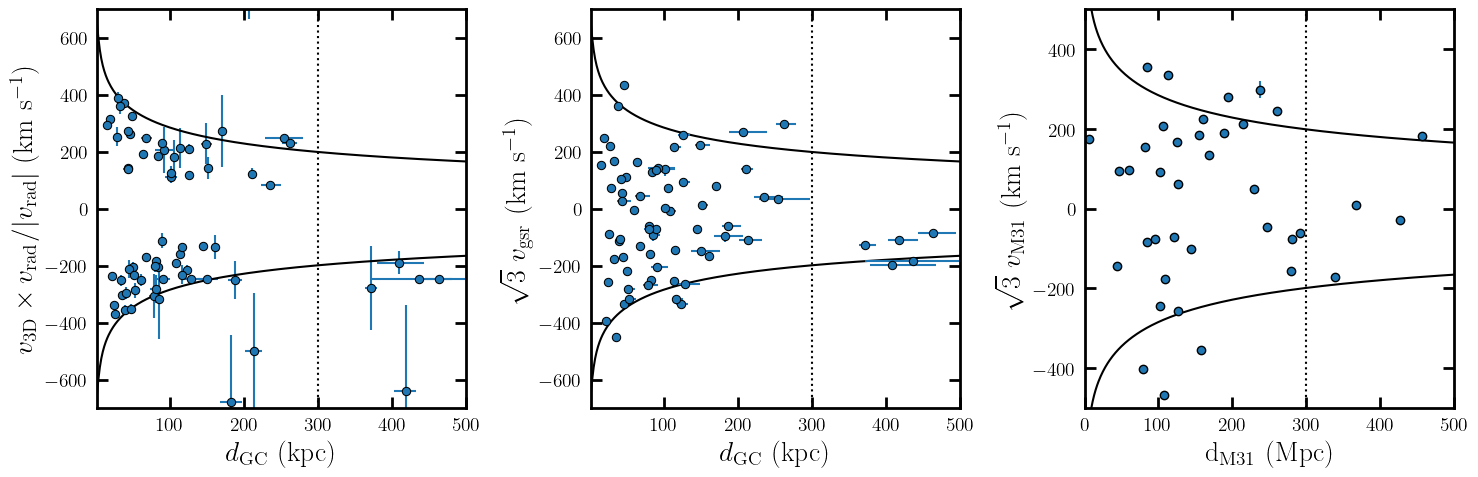

In [10]:
fig, ax = plt.subplots(1,3, figsize=(15,5))

ax[0].errorbar( dsph_mw['distance_gc'], dsph_mw['v3d']*dsph_mw['vrad']/abs(dsph_mw['vrad']), fmt='o', yerr=dsph_mw['v3d_error'], xerr=[dsph_mw['distance_gc_em'], dsph_mw['distance_gc_ep']],mec = 'k', mew=.75)

## for simplicity adds same escape velocity and virial radius line for MW and M31
rad = np.arange(1,500,1)
for i in [0,1, 2]:
    ax[i].plot(rad, vesc(MWPotential2014,rad/8.)*220., c='k')
    ax[i].plot(rad, -vesc(MWPotential2014,rad/8.)*220., c='k')
    ax[i].set_xlim(1,500)
    ax[i].set_ylim(-700,700)
    ax[i].axvline(300, c='k',ls=':')

ax[0].set_xlabel(r'$d_{\rm {\rm GC}}~({\rm kpc})$')
ax[0].set_ylabel(r'$v_{\rm {\rm 3D}}\times v_{\rm rad}/ | v_{\rm rad} |~({\rm km~s^{-1}})$')

ax[1].set_xlabel(r'$d_{\rm {\rm GC}}~({\rm kpc})$')
ax[1].set_ylabel(r'$\sqrt{3}~v_{\rm {\rm gsr}}~({\rm km~s^{-1}})$')

ax[1].errorbar( dsph_mw['distance_gc'], np.sqrt(3)*dsph_mw['vgsr'], fmt='o', yerr=[np.sqrt(3)*dsph_mw['vgsr_em'],dsph_mw['vgsr_em']], xerr= [dsph_mw['distance_gc_em'], np.sqrt(3)*dsph_mw['distance_gc_ep']],mec = 'k', mew=.75)

## velocity relative to M31
ax[2].errorbar(dsph_mw['distance_m31'], np.sqrt(3)*(dsph_mw['velocity_gsr'] - rv_gsr_m31), fmt='o', yerr=(dsph_mw['vlos_systemic_em']+dsph_mw['vlos_systemic_ep'])/2., mec='k')

ax[2].set_xlabel(r'${\rm d_{\rm M31}~(Mpc)}$')
ax[2].set_ylabel(r'$ \sqrt{3}~ v_{\rm M31}~({\rm km~s^{-1}})$')
ax[2].set_xlim(0,500)
ax[2].set_ylim(-500, 500)

plt.tight_layout()
#
plt.savefig('plots/rad_velocity_3panel.pdf')
plt.show()